In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SequentialSampler, Subset
from utils import get_lags, get_average, TrainHelper, Window, CoreDataset, evaluate_on_test, init_weights

In [3]:
class CoreDataset(Dataset):
    
    def __init__(self, df: pd.DataFrame, lags: int):
        # start from 1948
        core: pd.DataFrame = df[["CPIAUCSL", "UNRATE", "A191RO1Q156NBEA"]].loc["1948-01-01":]
        
        X = get_lags(core, lags)
        self.y = core[lags:].values
        self.X = X[lags:].values
        
    def __getitem__(self, index):
        return self.y[index], self.X[index]
    
    def __len__(self):
        return len(self.y)
    
    def plot(self):
        plt.plot(self.core)
        plt.show()

full = pd.read_csv('growth_rate.csv', index_col=0, header=[0] ,parse_dates=True)
coreDataset = CoreDataset(full, lags=3)

In [4]:
trainset = Subset(coreDataset, [i for i in range(700)])
testset = Subset(coreDataset, [i for i in range(701, len(coreDataset))])

trainloader = DataLoader(trainset, batch_size=1, 
                        shuffle=False,
                        sampler=SequentialSampler(trainset))

testloader = DataLoader(testset, batch_size=1, shuffle=False,
                        sampler=SequentialSampler(testset))

In [5]:
class Feedforward(nn.Module):
    
    def __init__(self):
        super(Feedforward, self).__init__()
        self.fc1 = nn.Linear(9, 6)
        self.fc2 = nn.Linear(6, 6)
        self.fc3 = nn.Linear(6, 3)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # no activation at output layer
        return x
    
net = Feedforward()

In [6]:
criterion = nn.MSELoss()
# decreasing the learning rate solved the problem
# https://stackoverflow.com/questions/35540269/keras-giving-same-loss-on-every-epoch
optimizer = optim.SGD(net.parameters(), lr=0.0001)

In [80]:
for epoch in range(5):
        
    for i, data in enumerate(trainloader):
        
        y, X = data
        y, X = y.float(), X.float()
        
        optimizer.zero_grad()
        
        y_pred = net(X)
        loss = criterion(y, y_pred)
        loss.backward()
        optimizer.step()
        
        if i % 200 == 199:
            print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, loss.item()))
            
print("Finished training")
        

[1,   200] loss: 9.180
[1,   400] loss: 10.306
[1,   600] loss: 1.290
[2,   200] loss: 0.501
[2,   400] loss: 1.708
[2,   600] loss: 0.635
[3,   200] loss: 0.147
[3,   400] loss: 1.114
[3,   600] loss: 0.348
[4,   200] loss: 0.037
[4,   400] loss: 0.832
[4,   600] loss: 0.329
[5,   200] loss: 0.032
[5,   400] loss: 0.719
[5,   600] loss: 0.333
Finished training


In [79]:
# to reset the weights
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
    
net.apply(init_weights)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """


Feedforward(
  (fc1): Linear(in_features=9, out_features=6, bias=True)
  (fc2): Linear(in_features=6, out_features=6, bias=True)
  (fc3): Linear(in_features=6, out_features=3, bias=True)
)

In [89]:
y_pred = []
y_act = []

with torch.no_grad():

    for i, data in enumerate(testloader):
        y, X = data
        y, X = y.float(), X.float()
        
        if i < 3:
            y_pred.append(net(X))
        else:
            temp_X = torch.cat((y_pred[i-1], y_pred[i-2], y_pred[i-3]), 1)
            y_pred.append(net(temp_X))
            
        y_act.append(y[0][0].item())


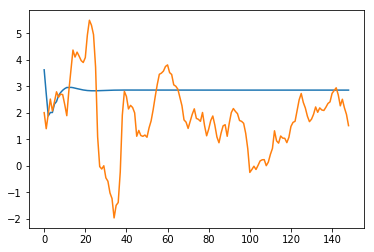

In [90]:
cpi_pred = []

for i in range(len(y_pred)):
    cpi_pred.append(y_pred[i].numpy().squeeze()[0])

plt.plot(cpi_pred)
plt.plot(y_act)


In [86]:
# do iterative forecasting - one vs four step ahead forecasting!
# sliding windows?

tensor([[1.9451, 3.9000, 3.1333, 2.1946, 3.7000, 3.0667, 2.5172, 3.8000, 3.0000]])